In [ ]:
!pip install spacy
!python -m spacy download en_core_web_sm


  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import pandas as pd
import re
import spacy
from bs4 import BeautifulSoup

# Load spaCy English NLP model
nlp = spacy.load("en_core_web_sm")

# Load the dataset
file_path = "/content/compiled.csv"
df = pd.read_csv(file_path)

# Combine question and answer text
df["text"] = df["question_body"].fillna("") + " " + df["answer_body"].fillna("")

# Function for text cleaning
def clean_text(text):
    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()

    # Remove special characters, numbers, and extra spaces
    text = re.sub(r"[^a-zA-Z\s]", "", text)

    # Convert to lowercase
    text = text.lower()

    # Process with spaCy (tokenization, stopword removal, lemmatization)
    doc = nlp(text)
    words = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]

    # Join words back into a single string
    return " ".join(words)

# Apply cleaning function to the text column
df["cleaned_text"] = df["text"].apply(clean_text)

# Save the processed dataset
processed_file_path = "processed_data_ianal.csv"
df.to_csv(processed_file_path, index=False)

print("Text preprocessing complete! Processed file saved as:", processed_file_path)


Text preprocessing complete! Processed file saved as: processed_data_ianal.csv


In [ ]:
import spacy

try:
    nlp = spacy.load("en_core_web_sm")
    print("spaCy model loaded successfully!")
except OSError:
    print("spaCy model not found. Try reinstalling.")


spaCy model loaded successfully!


In [ ]:
!pip install ace_tools

In [ ]:
import pandas as pd
import spacy
import re
import html
from lxml import etree

# Load spaCy English NLP model
nlp = spacy.load("en_core_web_sm")

# Function to remove HTML tags using lxml
def remove_html(text):
    if pd.isna(text):
        return ""

    # Decode HTML entities (e.g., &lt; becomes <, &amp; becomes &)
    text = html.unescape(text)

    # Parse with lxml to remove tags
    parser = etree.HTMLParser()
    tree = etree.fromstring(f"<root>{text}</root>", parser)
    text = "".join(tree.itertext())

    return text

# Function for advanced text cleaning
def clean_text(text):
    text = remove_html(text)  # First, remove HTML

    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)

    # Remove special characters, numbers, and extra spaces
    text = re.sub(r"[^a-zA-Z\s]", " ", text)

    # Convert to lowercase
    text = text.lower()

    # Process text using spaCy (Tokenization, Stopword Removal, Lemmatization)
    doc = nlp(text)
    words = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]

    # Join words back into a single string
    return " ".join(words)

# Load dataset
file_path = "compiled.csv"
df = pd.read_csv(file_path)

# Combine question and answer text and apply cleaning
df["cleaned_text"] = (df["question_body"].fillna("") + " " + df["answer_body"].fillna("")).apply(clean_text)

# Save the processed dataset
processed_file_path = "processed_merged_ianal_compiled.csv"
df.to_csv(processed_file_path, index=False)

  # Save the cleaned dataset locally
print("Processed data saved as processed_merged_ianal_compiled.csv")

Processed data saved as processed_merged_ianal_compiled.csv


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Load cleaned dataset
file_path = "processed_merged_ianal_compiled.csv"  # Use the correct path if needed
df = pd.read_csv(file_path)

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Limit to 5000 words

# Convert text to TF-IDF features
tfidf_matrix = tfidf_vectorizer.fit_transform(df["cleaned_text"])

# Convert to DataFrame for visualization
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Save or print sample results
tfidf_df.to_csv("tfidf_features.csv", index=False)
print("TF-IDF feature extraction complete. Data saved as tfidf_features.csv")


TF-IDF feature extraction complete. Data saved as tfidf_features.csv


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer
bow_vectorizer = CountVectorizer(max_features=5000)  # Limit vocabulary size

# Convert text to BoW features
bow_matrix = bow_vectorizer.fit_transform(df["cleaned_text"])

# Convert to DataFrame for visualization
bow_df = pd.DataFrame(bow_matrix.toarray(), columns=bow_vectorizer.get_feature_names_out())

# Save or print sample results
bow_df.to_csv("bow_features.csv", index=False)
print("BoW feature extraction complete. Data saved as bow_features.csv")

BoW feature extraction complete. Data saved as bow_features.csv


In [ ]:
import pandas as pd

# Step 1: Load the TF-IDF CSV
file_path = "tfidf_features.csv"
df = pd.read_csv(file_path)

# Step 2: Show basic information
print("\n=== DataFrame Shape ===")
print(df.shape)

print("\n=== Column names (features/terms) ===")
print(df.columns.tolist()[:10], "...")  # only printing first 10 for brevity

# Step 3: Check a few sample rows
print("\n=== Sample Rows ===")
print(df.head(3))

# Step 4: Check for NaN values (shouldn't happen in clean TF-IDF but let's be sure)
print("\n=== Missing Values ===")
print(df.isnull().sum().sum(), "missing values")

# Step 5: Quick statistics
print("\n=== Basic Statistics ===")
print(df.describe())

# Step 6: Analyze sparsity
total_cells = df.shape[0] * df.shape[1]
non_zero_cells = (df != 0).sum().sum()
sparsity = 100 * (1 - non_zero_cells / total_cells)

print(f"\n=== Sparsity of the TF-IDF matrix: {sparsity:.2f}% ===")

# Step 7: Find Top Terms Across All Documents
# Sum TF-IDF values across all posts
term_sums = df.sum().sort_values(ascending=False)

print("\n=== Top 10 Terms with Highest Overall TF-IDF Scores ===")
print(term_sums.head(10))

# Step 8: Find the most "unique" post (highest average TF-IDF)
df["average_tfidf"] = df.mean(axis=1)
most_unique_post_idx = df["average_tfidf"].idxmax()

print("\n=== Post with Highest Average TF-IDF (most 'unique' overall) ===")
print(df.iloc[most_unique_post_idx])



=== DataFrame Shape ===
(404, 5000)

=== Column names (features/terms) ===
['aac', 'ab', 'abandon', 'abcl', 'abide', 'ability', 'able', 'aboard', 'abode', 'abscond'] ...

=== Sample Rows ===
        aac   ab  abandon  abcl  abide  ability  able  aboard  abode  abscond  \
0  0.000000  0.0      0.0   0.0    0.0  0.02553   0.0     0.0    0.0      0.0   
1  0.686369  0.0      0.0   0.0    0.0  0.00000   0.0     0.0    0.0      0.0   
2  0.000000  0.0      0.0   0.0    0.0  0.00000   0.0     0.0    0.0      0.0   

   ...  zero  zip  zipalign  zipios  zips   zl  zlib  zone  zonesol  zypher  
0  ...   0.0  0.0       0.0     0.0   0.0  0.0   0.0   0.0      0.0     0.0  
1  ...   0.0  0.0       0.0     0.0   0.0  0.0   0.0   0.0      0.0     0.0  
2  ...   0.0  0.0       0.0     0.0   0.0  0.0   0.0   0.0      0.0     0.0  

[3 rows x 5000 columns]

=== Missing Values ===
0 missing values

=== Basic Statistics ===
              aac          ab     abandon        abcl       abide     ability  

In [ ]:
import pandas as pd

# Step 1: Load the Bag of Words CSV
bow_file_path = "bow_features.csv"
df_bow = pd.read_csv(bow_file_path)

# Step 2: Basic Info
print("\n=== DataFrame Shape ===")
print(df_bow.shape)

print("\n=== Column names (features/terms) ===")
print(df_bow.columns.tolist()[:10], "...")  # just the first 10 terms for preview

# Step 3: Sample Data
print("\n=== Sample Rows ===")
print(df_bow.head(3))

# Step 4: Check for missing values
print("\n=== Missing Values ===")
print(df_bow.isnull().sum().sum(), "missing values")

# Step 5: Basic statistics
print("\n=== Basic Statistics ===")
print(df_bow.describe())

# Step 6: Analyze Sparsity
total_cells = df_bow.shape[0] * df_bow.shape[1]
non_zero_cells = (df_bow != 0).sum().sum()
sparsity = 100 * (1 - non_zero_cells / total_cells)

print(f"\n=== Sparsity of the BoW matrix: {sparsity:.2f}% ===")

# Step 7: Find Most Common Words Across All Documents
word_counts = df_bow.sum().sort_values(ascending=False)

print("\n=== Top 10 Most Common Words Across All Posts ===")
print(word_counts.head(10))

# Step 8: Find the Post With Most Unique Words (high vocabulary usage)
df_bow["unique_word_count"] = (df_bow > 0).sum(axis=1)
most_unique_post_idx = df_bow["unique_word_count"].idxmax()

print("\n=== Post with Highest Number of Unique Words ===")
print(df_bow.iloc[most_unique_post_idx])



=== DataFrame Shape ===
(404, 5000)

=== Column names (features/terms) ===
['aac', 'ab', 'abandon', 'abcl', 'abide', 'ability', 'able', 'aboard', 'abode', 'abscond'] ...

=== Sample Rows ===
   aac  ab  abandon  abcl  abide  ability  able  aboard  abode  abscond  ...  \
0    0   0        0     0      0        1     0       0      0        0  ...   
1    7   0        0     0      0        0     0       0      0        0  ...   
2    0   0        0     0      0        0     0       0      0        0  ...   

   zero  zip  zipalign  zipios  zips  zl  zlib  zone  zonesol  zypher  
0     0    0         0       0     0   0     0     0        0       0  
1     0    0         0       0     0   0     0     0        0       0  
2     0    0         0       0     0   0     0     0        0       0  

[3 rows x 5000 columns]

=== Missing Values ===
0 missing values

=== Basic Statistics ===
              aac          ab     abandon        abcl       abide     ability  \
count  404.000000  404.000

In [ ]:
!pip uninstall -y gensim
!pip uninstall -y numpy



Found existing installation: numpy 1.24.3
Uninstalling numpy-1.24.3:
  Successfully uninstalled numpy-1.24.3


In [ ]:
!pip install numpy



  Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 115.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.5 which is incompatible.


In [ ]:
!pip install ace_tools

In [ ]:
!pip install --upgrade --force-reinstall numpy gensim


  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached smart_open-7.1.0-py3-none-any.whl.metadata (24 kB)
  Using cached wrapt-1.17.2-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.4 kB)
Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.7 MB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.6 MB)
Using cached smart_open-7.1.0-py3-none-any.whl (61 kB)
Using cached wrapt-1.17.2-cp311-cp

In [ ]:
import pandas as pd
import re
import spacy
from bs4 import BeautifulSoup

# Load spaCy English NLP model
nlp = spacy.load("en_core_web_sm")

# Load the dataset
file_path = "/content/processed_merged_ianal_compiled.csv"
df = pd.read_csv(file_path)

# Combine question and answer text
df["text"] = df["question_body"].fillna("") + " " + df["answer_body"].fillna("")

# Function for text cleaning
def clean_text(text):
    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()

    # Remove special characters, numbers, and extra spaces
    text = re.sub(r"[^a-zA-Z\s]", "", text)

    # Convert to lowercase
    text = text.lower()

    # Process with spaCy (tokenization, stopword removal, lemmatization)
    doc = nlp(text)
    words = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]

    # Join words back into a single string
    return " ".join(words)

# Apply cleaning function to the text column
df["cleaned_text"] = df["text"].apply(clean_text)

# Save the processed dataset
processed_file_path = "processed_data_ianal.csv"
df.to_csv(processed_file_path, index=False)

print("Text preprocessing complete! Processed file saved as:", processed_file_path)


Text preprocessing complete! Processed file saved as: processed_data_ianal.csv


In [ ]:
import spacy

try:
    nlp = spacy.load("en_core_web_sm")
    print("spaCy model loaded successfully!")
except OSError:
    print("spaCy model not found. Try reinstalling.")


spaCy model loaded successfully!


In [ ]:
!pip install gensim scikit-learn

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary

# Load cleaned dataset
file_path = "/content/processed_merged_ianal_compiled.csv"
df = pd.read_csv(file_path)

# Tokenize text for LDA
tokenized_texts = df["cleaned_text"].apply(lambda x: x.split())

# Create dictionary and corpus for LDA
dictionary = Dictionary(tokenized_texts)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

# Define number of topics
num_topics = 5  # You can tune this number

# Train LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10)

# Display topics with top words
topics = lda_model.print_topics(num_words=10)
for topic_id, topic_words in topics:
    print(f"Topic {topic_id+1}: {topic_words}")


Topic 1: 0.050*"license" + 0.017*"work" + 0.011*"patent" + 0.011*"use" + 0.010*"s" + 0.010*"copyright" + 0.010*"software" + 0.010*"code" + 0.009*"t" + 0.008*"source"
Topic 2: 0.013*"s" + 0.010*"t" + 0.010*"source" + 0.007*"use" + 0.007*"license" + 0.006*"modify" + 0.006*"need" + 0.005*"work" + 0.005*"software" + 0.004*"file"
Topic 3: 0.030*"license" + 0.022*"code" + 0.019*"source" + 0.016*"gpl" + 0.015*"s" + 0.013*"use" + 0.012*"software" + 0.012*"t" + 0.011*"library" + 0.009*"work"
Topic 4: 0.022*"gpl" + 0.018*"code" + 0.015*"license" + 0.015*"s" + 0.014*"program" + 0.011*"work" + 0.010*"use" + 0.010*"t" + 0.008*"software" + 0.007*"source"
Topic 5: 0.015*"copyright" + 0.014*"code" + 0.006*"ianal" + 0.006*"need" + 0.006*"work" + 0.005*"s" + 0.005*"original" + 0.005*"repository" + 0.005*"t" + 0.005*"source"


In [ ]:
!pip install pyLDAvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 29.2 MB/s eta 0:00:00


In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Prepare visualization
lda_display = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)


In [ ]:
from textblob import TextBlob

# Function to get sentiment score (-1 to 1)
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Apply sentiment analysis
df["sentiment_score"] = df["cleaned_text"].apply(get_sentiment)

# Categorize sentiment
df["sentiment_label"] = df["sentiment_score"].apply(lambda x: "Negative" if x < 0 else "Neutral" if x == 0 else "Positive")

# Print sentiment distribution
print(df["sentiment_label"].value_counts())

# Save results
df.to_csv("ianal_sentiment_analysis.csv", index=False)


sentiment_label
Positive    352
Negative     51
Neutral       1
Name: count, dtype: int64


In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Ensure VADER is downloaded
nltk.download("vader_lexicon")

# Initialize VADER
sia = SentimentIntensityAnalyzer()

# Function to get VADER sentiment score
def get_vader_sentiment(text):
    sentiment_score = sia.polarity_scores(text)["compound"]  # Compound score (-1 to 1)

    # Custom thresholds for better descriptive labels
    if sentiment_score >= 0.5:
        return "Confident"
    elif sentiment_score > 0.1:
        return "Positive but Cautious"
    elif sentiment_score < -0.1:
        return "Uncertain/Cautious"
    elif sentiment_score <= -0.5:
        return "Strongly Negative"
    else:
        return "Neutral"

# Apply the function
df["vader_sentiment_label"] = df["cleaned_text"].apply(get_vader_sentiment)

# Print updated sentiment breakdown
print(df["vader_sentiment_label"].value_counts())

# Save new sentiment labels
df.to_csv("ianal_vader_sentiment_analysis.csv", index=False)


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


vader_sentiment_label
Confident                353
Positive but Cautious     26
Uncertain/Cautious        21
Neutral                    4
Name: count, dtype: int64


In [ ]:
!pip install PyPDF2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 4.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from PyPDF2 import PdfReader
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import joblib

# Step 1: Extract Text from Official License PDFs & Google Open Source Casebook
pdf_files = [
    "/content/Apache License, Version 2.0 – Open Source Initiative.pdf",
    "/content/GNU Affero General Public License version 3 – Open Source Initiative.pdf",
    "/content/GNU General Public License version 2 – Open Source Initiative.pdf",
    "/content/GNU General Public License version 3 – Open Source Initiative.pdf",
    "/content/GNU Lesser General Public License version 2.1 – Open Source Initiative.pdf"
]

# Read and extract text from PDFs
license_texts = {}
for pdf_file in pdf_files:
    reader = PdfReader(pdf_file)
    text = "\n".join([page.extract_text() for page in reader.pages if page.extract_text()])
    license_texts[pdf_file] = text

# Combine all license texts
license_corpus = list(license_texts.values())

# Step 2: Load Forum Answers CSV
forum_answers_file = "/content/processed_merged_ianal_compiled.csv"
forum_data = pd.read_csv(forum_answers_file)

# Ensure correct column names (adjust if needed)
expected_columns = ['post_type', 'post_id', 'creation_date', 'question_id', 'question_title', 'question_body', 'answer_body']
forum_data = forum_data[expected_columns]

# Step 3: Compute Similarity Between Answers and Official License Texts
vectorizer = TfidfVectorizer()
doc_vectors = vectorizer.fit_transform(license_corpus)  # License texts
answer_vectors = vectorizer.transform(forum_data['answer_body'].fillna(''))  # Forum answers

# Compute cosine similarity
similarities = cosine_similarity(answer_vectors, doc_vectors)

# Step 4: Assign Labels Based on Similarity Score
def assign_label(sim_score):
    if max(sim_score) >= 0.60:
        return "Accurate"
    elif max(sim_score) <= 0.40:
        return "Inaccurate"
    else:
        return "Needs Review"

# Apply labeling function
forum_data["Accuracy_Label"] = [assign_label(sim) for sim in similarities]

# Step 5: Encode Labels for Model Training
label_mapping = {"Accurate": 2, "Needs Review": 1, "Inaccurate": 0}  # Explicit label mapping
forum_data["Label_Encoded"] = forum_data["Accuracy_Label"].map(label_mapping)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(answer_vectors, forum_data["Label_Encoded"], test_size=0.2, random_state=42)

# Train Random Forest Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Print Evaluation Metrics
print("Classification Report:\n", classification_report(y_test, y_pred))

# Save the Labeled Data and Model for Download
forum_data.to_csv("/content/labeled_forum_answers.csv", index=False)
joblib.dump(model, "/content/license_accuracy_model.pkl")

print("\nProcessing complete! Download results:")
print("Labeled Data: /content/labeled_forum_answers.csv")
print("Trained Model: /content/license_accuracy_model.pkl")


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.50      0.67         8
           1       0.62      0.23      0.33        22
           2       0.74      1.00      0.85        51

    accuracy                           0.74        81
   macro avg       0.79      0.58      0.62        81
weighted avg       0.73      0.74      0.69        81


Processing complete! Download results:
Labeled Data: /content/labeled_forum_answers.csv
Trained Model: /content/license_accuracy_model.pkl


In [ ]:
!pip install transformers torch

In [ ]:
import pandas as pd

# 1. Load your original CSV
df = pd.read_csv("/content/processed_merged_ianal_compiled.csv")

# 2. Filter out rows where post_type is "question"
df_answers_only = df[df["post_type"] == "answer"].copy()

# 3. Write the resulting DataFrame to a new CSV
#    This CSV will keep the original columns but contain only answer rows.
df_answers_only.to_csv("answers_only.csv", index=False)

print("Filtered CSV created with only 'answer' rows!")


Filtered CSV created with only 'answer' rows!


In [ ]:
import pandas as pd
from transformers import pipeline


In [ ]:
df = pd.read_csv("answers_only.csv")


In [ ]:
summarizer = pipeline("summarization", model="sshleifer/distilbart-cnn-12-6", device=0)

Device set to use cuda:0


In [ ]:
def clean_text(text):
    if not isinstance(text, str):
        return ""
    # Remove non-printable / control chars:
    text = "".join(ch for ch in text if ch.isprintable())
    return text

df["question_body"] = df["question_body"].apply(clean_text)
df["answer_body"]   = df["answer_body"].apply(clean_text)


In [ ]:
summarizer = pipeline(
    "summarization",
    model="facebook/bart-large-cnn",
    device=-1  # forces CPU usage
)


config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu


In [ ]:
!pip install --upgrade transformers datasets torch torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 86.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.50.3
    Uninstalling transformers-4.50.3:
      Successfully uninstalled transformers-4.50.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
g

In [ ]:
!pip install pandas numpy torch transformers datasets

In [ ]:
!pip install --upgrade transformers datasets torch

In [ ]:
!pip install torchvision

In [ ]:
# 1. Load the CSV
import pandas as pd
df = pd.read_csv("answers_only.csv")

# (Optional) Check the first few rows/columns
print(df.head())
print(df.columns)


  post_type  post_id  creation_date  question_id  \
0    answer  1073443     1536433757      1072568   
1    answer   581248     1422974434       548985   
2    answer   403491     1389367775       403482   
3    answer   275762     1364554173       275742   
4    answer   297775     1369053456       297756   

                                      question_title  \
0              Add flag to existing terminal command   
1                         Icecast on linux using AAC   
2                           Are PDF files opensouce?   
3         How to delete private data from log files?   
4  How can I report a suspected copyright or trad...   

                                       question_body  \
0  <p>From this question: <a href="https://askubu...   
1  <p>I'm pretty new to using Icecast. We are str...   
2  <p>I was just wondering if PDF formats are ope...   
3  <p>I have heard that log files contains privat...   
4  <p><strong>The problem:</strong> The applicati...   

             

In [ ]:
import pandas as pd
from datasets import Dataset
from transformers import pipeline
import torch


In [ ]:
summarizer = pipeline(
    "summarization",
    model="sshleifer/distilbart-cnn-12-6",
    device=0  # 0 for GPU; -1 for CPU
)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cuda:0


In [ ]:
# 1. Load the CSV
df = pd.read_csv("/content/processed_merged_ianal_compiled.csv")

# (Optional) Check the first few rows/columns
print(df.head())
print(df.columns)

  post_type  post_id  creation_date  question_id  \
0    answer  1073443     1536433757      1072568   
1    answer   581248     1422974434       548985   
2    answer   403491     1389367775       403482   
3    answer   275762     1364554173       275742   
4    answer   297775     1369053456       297756   

                                      question_title  \
0              Add flag to existing terminal command   
1                         Icecast on linux using AAC   
2                           Are PDF files opensouce?   
3         How to delete private data from log files?   
4  How can I report a suspected copyright or trad...   

                                       question_body  \
0  <p>From this question: <a href="https://askubu...   
1  <p>I'm pretty new to using Icecast. We are str...   
2  <p>I was just wondering if PDF formats are ope...   
3  <p>I have heard that log files contains privat...   
4  <p><strong>The problem:</strong> The applicati...   

             

In [ ]:
!pip install sentence-transformers PyPDF2 pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 4.0 MB/s eta 0:00:00


In [ ]:
import os
import PyPDF2

license_files = [
    "Apache License, Version 2.0 – Open Source Initiative.pdf",
    "Apache Software License, version 1.1 – Open Source Initiative.pdf",
    "GNU Affero General Public License version 3 – Open Source Initiative.pdf",
    "GNU General Public License version 2 – Open Source Initiative.pdf",
    "GNU General Public License version 3 – Open Source Initiative.pdf",
    "GNU Lesser General Public License version 2.1 – Open Source Initiative.pdf",
    "GNU Lesser General Public License version 3 – Open Source Initiative.pdf",
    "GNU Library General Public License version 2 – Open Source Initiative.pdf",
    "The MIT License – Open Source Initiative.pdf",
    "The Nethack General Public License – Open Source Initiative.pdf"
]

def extract_text_from_pdf(pdf_path):
    """
    Reads a PDF file with PyPDF2 and returns the extracted text.
    """
    text = ""
    with open(pdf_path, 'rb') as f:
        reader = PyPDF2.PdfReader(f)
        for page in reader.pages:
            page_text = page.extract_text()
            if page_text:
                text += page_text + "\n"
    return text

licenses_dict = {}
for pdf_name in license_files:
    pdf_path = os.path.join('/content/', pdf_name)
    if os.path.isfile(pdf_path):
        extracted_text = extract_text_from_pdf(pdf_path)
        licenses_dict[pdf_name] = extracted_text
    else:
        print(f"Warning: file not found - {pdf_path}")


In [ ]:
import os
import PyPDF2
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

###########################
# Step 1: Extract PDF text
###########################

def extract_text_from_pdf(pdf_path):
    """
    Reads a PDF file with PyPDF2 and returns the extracted text.
    """
    text = ""
    with open(pdf_path, 'rb') as f:
        reader = PyPDF2.PdfReader(f)
        for page in reader.pages:
            page_text = page.extract_text()
            if page_text:
                text += page_text + "\n"
    return text

license_files = [
    "Apache License, Version 2.0 – Open Source Initiative.pdf",
    "Apache Software License, version 1.1 – Open Source Initiative.pdf",
    "GNU Affero General Public License version 3 – Open Source Initiative.pdf",
    "GNU General Public License version 2 – Open Source Initiative.pdf",
    "GNU General Public License version 3 – Open Source Initiative.pdf",
    "GNU Lesser General Public License version 2.1 – Open Source Initiative.pdf",
    "GNU Lesser General Public License version 3 – Open Source Initiative.pdf",
    "GNU Library General Public License version 2 – Open Source Initiative.pdf",
    "The MIT License – Open Source Initiative.pdf",
    "The Nethack General Public License – Open Source Initiative.pdf"
]

licenses_dict = {}
for pdf_name in license_files:
    pdf_path = os.path.join('/content/', pdf_name)
    if os.path.isfile(pdf_path):
        extracted_text = extract_text_from_pdf(pdf_path)
        licenses_dict[pdf_name] = extracted_text
    else:
        print(f"Warning: file not found: {pdf_path}")

###############################
# Step 2: Embed & compare text
###############################

# Load the Sentence Transformer
model = SentenceTransformer("all-MiniLM-L6-v2")

# Read your CSV of forum posts
df = pd.read_csv("/content/answers_only.csv")

# Here we assume the column is named "answer_body"
text_column_name = "answer_body"

# Embed each license text once
license_embeddings = {}
for lic_name, lic_text in licenses_dict.items():
    emb = model.encode(lic_text)
    license_embeddings[lic_name] = emb

def compute_similarities(post_text):
    """
    Returns a dict of license_name -> similarity_score for a given forum post's text.
    """
    post_emb = model.encode(post_text).reshape(1, -1)
    similarities = {}
    for lic_name, lic_emb in license_embeddings.items():
        lic_emb_2d = lic_emb.reshape(1, -1)
        sim = cosine_similarity(post_emb, lic_emb_2d)[0][0]
        similarities[lic_name] = float(sim)
    return similarities

df["similarities"] = df[text_column_name].apply(compute_similarities)

# Expand dict of similarity scores into columns
for lic_name in license_files:
    df[lic_name] = df["similarities"].apply(lambda d: d.get(lic_name, 0.0))

# Drop the dictionary column if you want
df.drop(columns=["similarities"], inplace=True)

# View or save
print(df.head(3))
df.to_csv("/content/forum_posts_with_license_similarities.csv", index=False)


  post_type  post_id  creation_date  question_id  \
0    answer  1073443     1536433757      1072568   
1    answer   581248     1422974434       548985   
2    answer   403491     1389367775       403482   

                          question_title  \
0  Add flag to existing terminal command   
1             Icecast on linux using AAC   
2               Are PDF files opensouce?   

                                       question_body  \
0  <p>From this question: <a href="https://askubu...   
1  <p>I'm pretty new to using Icecast. We are str...   
2  <p>I was just wondering if PDF formats are ope...   

                                         answer_body  \
0  <h3>Adding flags and existing commands</h3>\n\...   
1  <p>Icecast does not <em>officially</em> suppor...   
2  <p>The PDF format itself is freely usable and ...   

                                        cleaned_text  \
0  question   ls list file rm remove    fkraiem c...   
1  m pretty new icecast   stream mp s linux box i...

In [ ]:
import os
import PyPDF2
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import pipeline

###########################################
# Step 1: Set up the summarization pipeline
###########################################
# We use a model like "facebook/bart-large-cnn" for summarization.
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

###########################################
# Step 2: Define a chunking and summarization function
###########################################
def summarize_long_text(text, max_chunk_words=300,
                        chunk_max_length=150, chunk_min_length=50,
                        final_max_length=130, final_min_length=30):
    """
    For a long text, split it into chunks (by word count),
    summarize each chunk, join the summaries and then summarize the joined text.

    Parameters:
      text (str): The text to summarize.
      max_chunk_words (int): Maximum words per chunk.
      chunk_max_length (int): max_length passed to summarizer for each chunk.
      chunk_min_length (int): min_length passed to summarizer for each chunk.
      final_max_length (int): max_length for final summary.
      final_min_length (int): min_length for final summary.

    Returns:
      final_summary (str): The final summarized text.
    """
    # Split text into words
    words = text.split()
    if not words:
        return ""

    chunks = []
    current_chunk = []
    for word in words:
        current_chunk.append(word)
        if len(current_chunk) >= max_chunk_words:
            chunks.append(" ".join(current_chunk))
            current_chunk = []
    # Add any remaining words
    if current_chunk:
        chunks.append(" ".join(current_chunk))

    # Summarize each chunk
    chunk_summaries = []
    for chunk in chunks:
        try:
            summary_list = summarizer(chunk, max_length=chunk_max_length,
                                        min_length=chunk_min_length, do_sample=False)
            chunk_summary = summary_list[0]['summary_text']
        except Exception as e:
            # In case summarization fails, fall back to the chunk itself
            print("Summarization error:", e)
            chunk_summary = chunk
        chunk_summaries.append(chunk_summary)

    # Combine chunk summaries and summarize them to get the final summary
    combined_summary_text = " ".join(chunk_summaries)
    try:
        final_summary_list = summarizer(combined_summary_text, max_length=final_max_length,
                                        min_length=final_min_length, do_sample=False)
        final_summary = final_summary_list[0]['summary_text']
    except Exception as e:
        print("Final summarization error:", e)
        final_summary = combined_summary_text
    return final_summary

###########################################
# Step 3: Extract text from license PDFs
###########################################
def extract_text_from_pdf(pdf_path):
    """
    Reads a PDF file and extracts its text.
    """
    text = ""
    with open(pdf_path, 'rb') as f:
        reader = PyPDF2.PdfReader(f)
        for page in reader.pages:
            page_text = page.extract_text()
            if page_text:
                text += page_text + "\n"
    return text

license_files = [
    "Apache License, Version 2.0 – Open Source Initiative.pdf",
    "Apache Software License, version 1.1 – Open Source Initiative.pdf",
    "GNU Affero General Public License version 3 – Open Source Initiative.pdf",
    "GNU General Public License version 2 – Open Source Initiative.pdf",
    "GNU General Public License version 3 – Open Source Initiative.pdf",
    "GNU Lesser General Public License version 2.1 – Open Source Initiative.pdf",
    "GNU Lesser General Public License version 3 – Open Source Initiative.pdf",
    "GNU Library General Public License version 2 – Open Source Initiative.pdf",
    "The MIT License – Open Source Initiative.pdf",
    "The Nethack General Public License – Open Source Initiative.pdf"
]

licenses_dict = {}
for pdf_name in license_files:
    pdf_path = os.path.join('/content/', pdf_name)
    if os.path.isfile(pdf_path):
        licenses_dict[pdf_name] = extract_text_from_pdf(pdf_path)
    else:
        print(f"Warning: file not found: {pdf_path}")

###########################################
# Step 4: Embed text using SentenceTransformer and compute similarity
###########################################
# Load the SentenceTransformer model
embedder = SentenceTransformer("all-MiniLM-L6-v2")

# Read your CSV of forum posts; assume forum text is in 'answer_body'
df = pd.read_csv("/content/answers_only.csv")
text_column_name = "answer_body"

# For each forum post, create a summary using the chunking function.
print("Summarizing forum posts...")
df["summary"] = df[text_column_name].apply(lambda x: summarize_long_text(x))

# Embed each license text once
license_embeddings = {}
for lic_name, lic_text in licenses_dict.items():
    license_embeddings[lic_name] = embedder.encode(lic_text)

def compute_similarities_from_summary(summary_text):
    """
    Compute cosine similarities between a summary and each license embedding.
    """
    summary_emb = embedder.encode(summary_text).reshape(1, -1)
    similarities = {}
    for lic_name, lic_emb in license_embeddings.items():
        sim = cosine_similarity(summary_emb, lic_emb.reshape(1, -1))[0][0]
        similarities[lic_name] = float(sim)
    return similarities

# Compute similarity scores for each summarized forum post
print("Computing similarity scores...")
df["similarities"] = df["summary"].apply(compute_similarities_from_summary)

# Expand the dictionary of similarities into separate columns (one per license PDF)
for lic_name in license_files:
    df[lic_name] = df["similarities"].apply(lambda d: d.get(lic_name, 0.0))

# Optionally drop the dictionary column
df.drop(columns=["similarities"], inplace=True)

# Preview the results and save the final DataFrame to CSV
print(df.head(3))
output_csv = "/content/forum_posts_summary_license_similarities.csv"
df.to_csv(output_csv, index=False)
print(f"Results saved to {output_csv}")


Device set to use cuda:0


Summarizing forum posts...


Your max_length is set to 130, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)
Your max_length is set to 130, but your input_length is only 59. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 150, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Your max_length is set to 130, but your input_length is only 111. Since this is a summarization task, where outputs shorter than the input are t

Computing similarity scores...
  post_type  post_id  creation_date  question_id  \
0    answer  1073443     1536433757      1072568   
1    answer   581248     1422974434       548985   
2    answer   403491     1389367775       403482   

                          question_title  \
0  Add flag to existing terminal command   
1             Icecast on linux using AAC   
2               Are PDF files opensouce?   

                                       question_body  \
0  <p>From this question: <a href="https://askubu...   
1  <p>I'm pretty new to using Icecast. We are str...   
2  <p>I was just wondering if PDF formats are ope...   

                                         answer_body  \
0  <h3>Adding flags and existing commands</h3>\n\...   
1  <p>Icecast does not <em>officially</em> suppor...   
2  <p>The PDF format itself is freely usable and ...   

                                        cleaned_text  \
0  question   ls list file rm remove    fkraiem c...   
1  m pretty new iceca

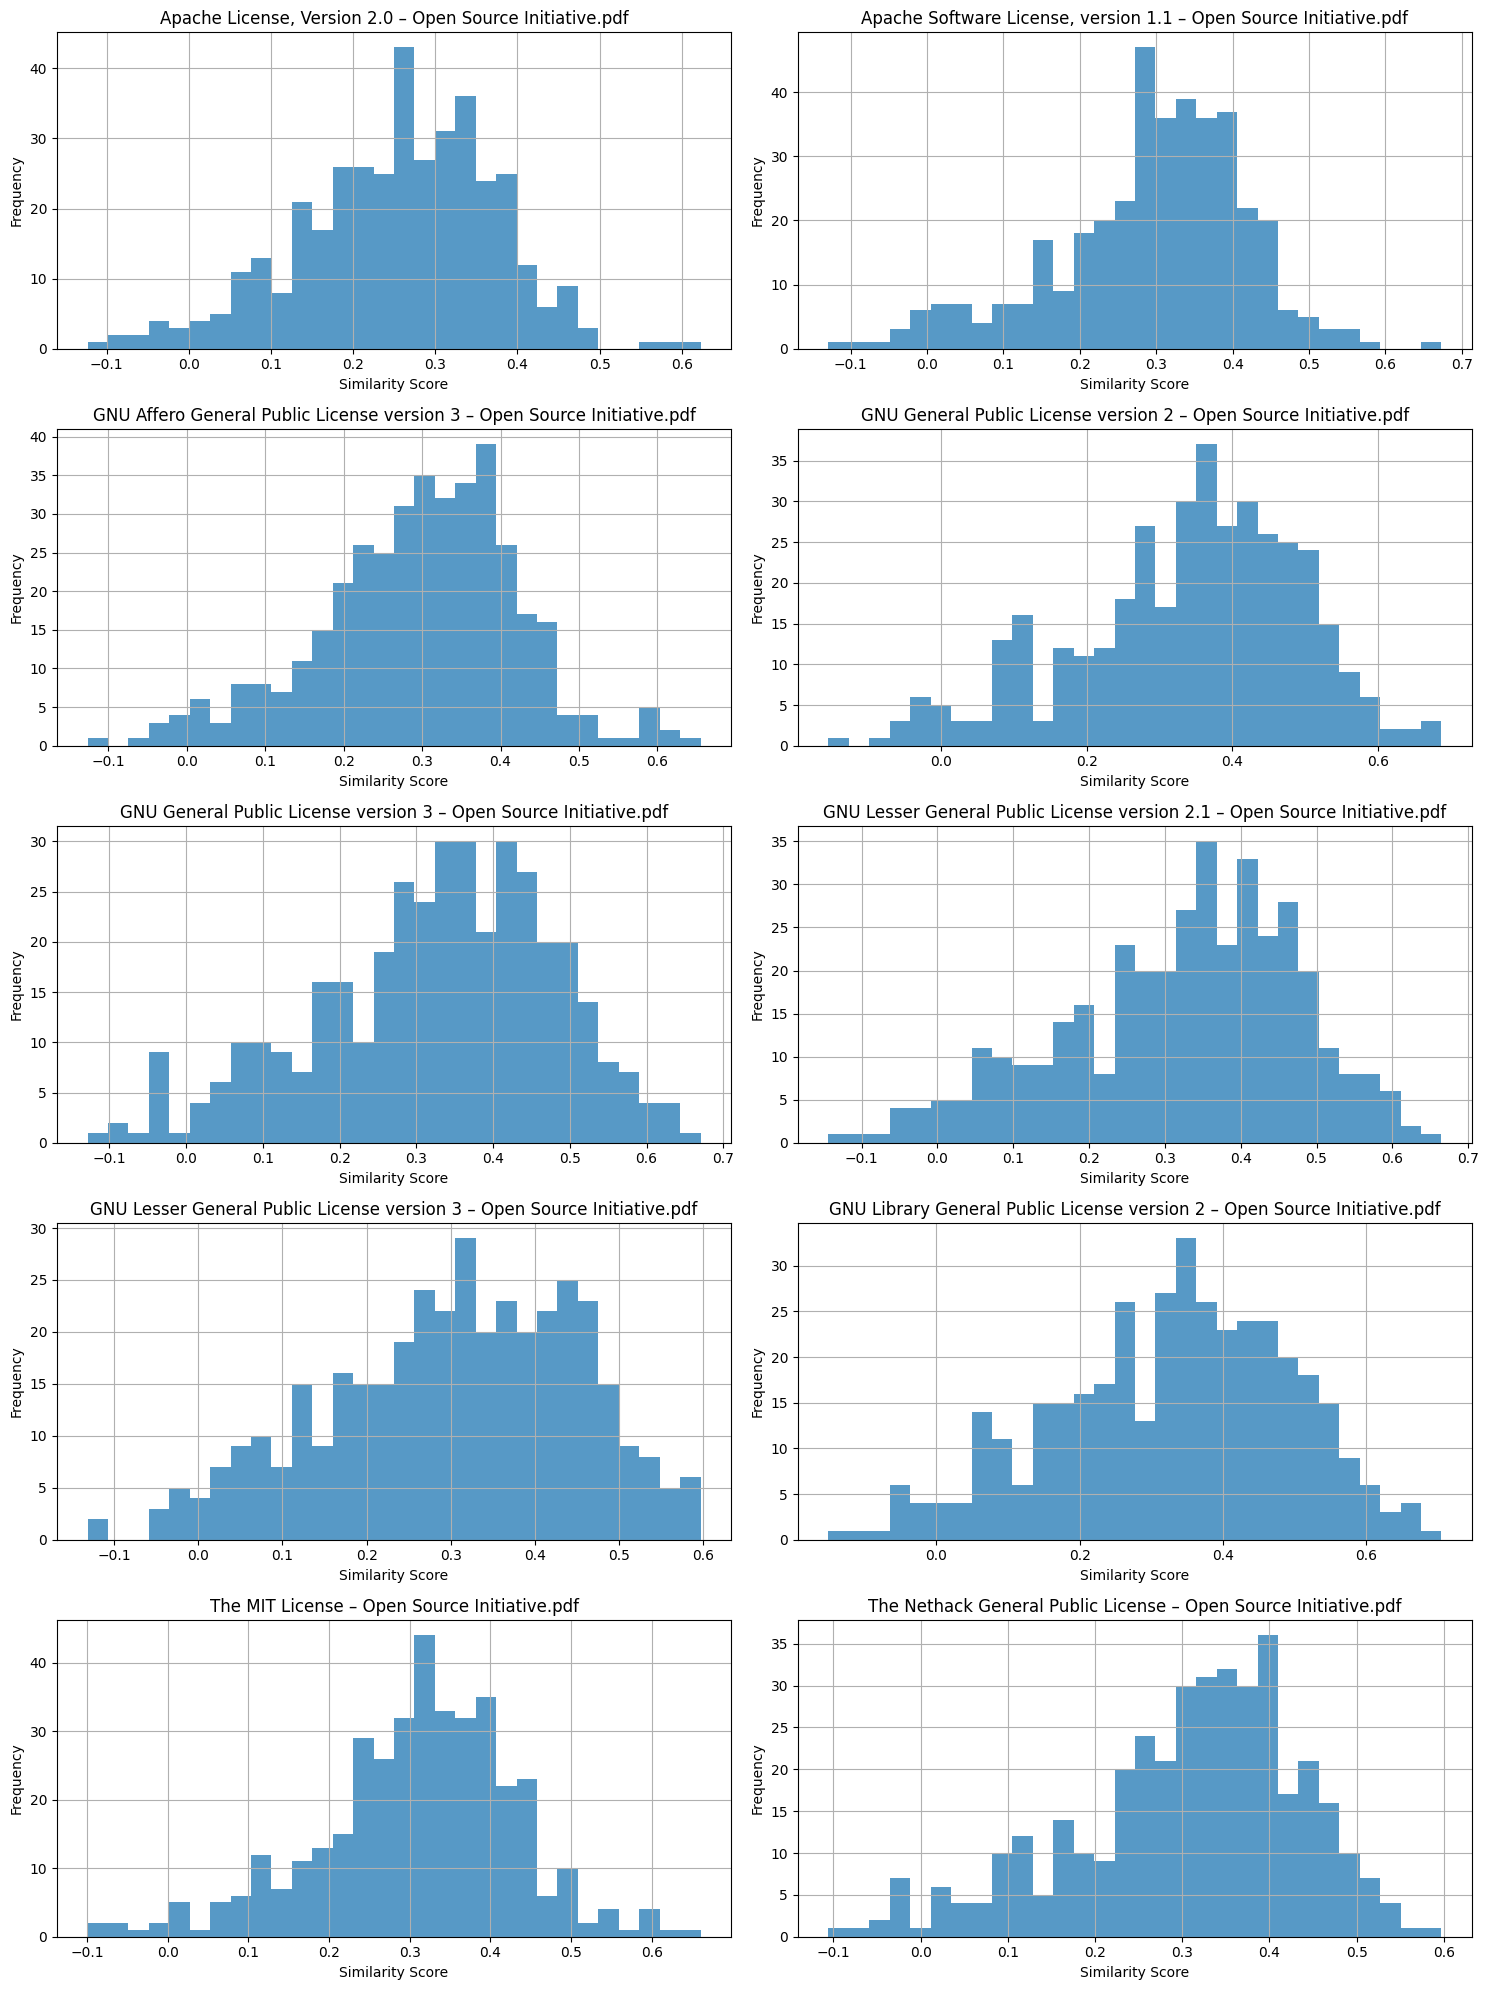

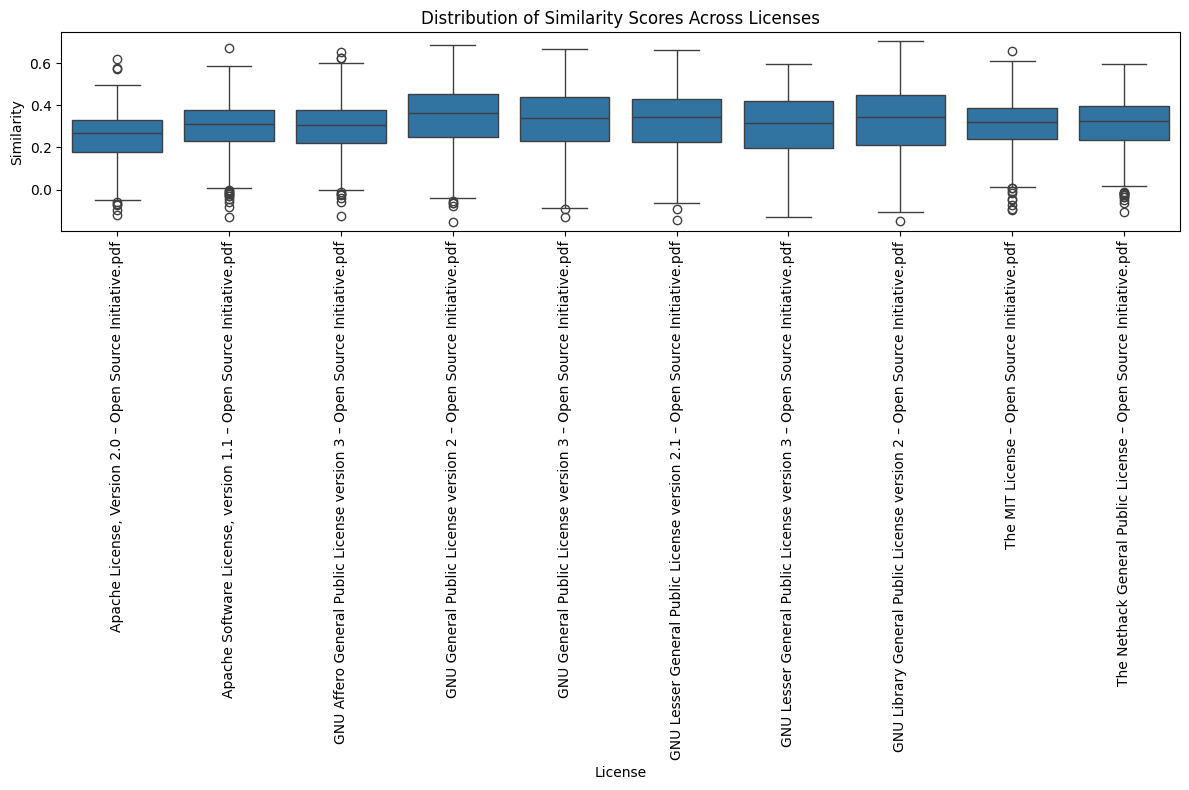

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
csv_file = "/content/forum_posts_summary_license_similarities.csv"
df = pd.read_csv(csv_file)

# List of license PDF column names (adjust if your CSV has different column names)
license_files = [
    "Apache License, Version 2.0 – Open Source Initiative.pdf",
    "Apache Software License, version 1.1 – Open Source Initiative.pdf",
    "GNU Affero General Public License version 3 – Open Source Initiative.pdf",
    "GNU General Public License version 2 – Open Source Initiative.pdf",
    "GNU General Public License version 3 – Open Source Initiative.pdf",
    "GNU Lesser General Public License version 2.1 – Open Source Initiative.pdf",
    "GNU Lesser General Public License version 3 – Open Source Initiative.pdf",
    "GNU Library General Public License version 2 – Open Source Initiative.pdf",
    "The MIT License – Open Source Initiative.pdf",
    "The Nethack General Public License – Open Source Initiative.pdf"
]

#######################################
# Option 1: Plot individual histograms
#######################################
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))
axes = axes.flatten()

for ax, lic in zip(axes, license_files):
    values = df[lic]
    ax.hist(values, bins=30, alpha=0.75)
    ax.set_title(lic)
    ax.set_xlabel("Similarity Score")
    ax.set_ylabel("Frequency")
    # Optionally add a grid
    ax.grid(True)

plt.tight_layout()
plt.show()

#######################################
# Option 2: Create a combined boxplot
#######################################
# Melt the DataFrame to get a long-form DataFrame that is easier to plot together
df_melted = df[license_files].melt(var_name="License", value_name="Similarity")

plt.figure(figsize=(12, 8))
sns.boxplot(x="License", y="Similarity", data=df_melted)
plt.xticks(rotation=90)
plt.title("Distribution of Similarity Scores Across Licenses")
plt.tight_layout()
plt.show()


Zero shot

In [ ]:
import pandas as pd
import PyPDF2
from transformers import pipeline
import os


In [ ]:
df = pd.read_csv("/content/processed_merged_ianal_compiled.csv")
print(df.head())


  post_type  post_id  creation_date  question_id  \
0    answer  1073443     1536433757      1072568   
1    answer   581248     1422974434       548985   
2    answer   403491     1389367775       403482   
3    answer   275762     1364554173       275742   
4    answer   297775     1369053456       297756   

                                      question_title  \
0              Add flag to existing terminal command   
1                         Icecast on linux using AAC   
2                           Are PDF files opensouce?   
3         How to delete private data from log files?   
4  How can I report a suspected copyright or trad...   

                                       question_body  \
0  <p>From this question: <a href="https://askubu...   
1  <p>I'm pretty new to using Icecast. We are str...   
2  <p>I was just wondering if PDF formats are ope...   
3  <p>I have heard that log files contains privat...   
4  <p><strong>The problem:</strong> The applicati...   

             

In [ ]:
pdf_files = [
    "Apache License, Version 2.0 – Open Source Initiative.pdf",
    "Apache Software License, version 1.1 – Open Source Initiative.pdf",
    "GNU Affero General Public License version 3 – Open Source Initiative.pdf",
    "GNU General Public License version 2 – Open Source Initiative.pdf",
    "GNU General Public License version 3 – Open Source Initiative.pdf",
    "GNU Lesser General Public License version 2.1 – Open Source Initiative.pdf",
    "GNU Lesser General Public License version 3 – Open Source Initiative.pdf",
    "GNU Library General Public License version 2 – Open Source Initiative.pdf",
    "The MIT License – Open Source Initiative.pdf",
    "The Nethack General Public License – Open Source Initiative.pdf"
]

license_texts = {}

for pdf_name in pdf_files:
    pdf_path = f"{pdf_name}"
    if os.path.exists(pdf_path):
        with open(pdf_path, "rb") as f:
            reader = PyPDF2.PdfReader(f)
            pages_text = []
            for page in reader.pages:
                text = page.extract_text()
                if text:
                    pages_text.append(text)
            full_text = "\n".join(pages_text)
            license_texts[pdf_name] = full_text
    else:
        print(f"File not found: {pdf_name}")

print("Extracted text for these PDFs:", license_texts.keys())


Extracted text for these PDFs: dict_keys(['Apache License, Version 2.0 – Open Source Initiative.pdf', 'Apache Software License, version 1.1 – Open Source Initiative.pdf', 'GNU Affero General Public License version 3 – Open Source Initiative.pdf', 'GNU General Public License version 2 – Open Source Initiative.pdf', 'GNU General Public License version 3 – Open Source Initiative.pdf', 'GNU Lesser General Public License version 2.1 – Open Source Initiative.pdf', 'GNU Lesser General Public License version 3 – Open Source Initiative.pdf', 'GNU Library General Public License version 2 – Open Source Initiative.pdf', 'The MIT License – Open Source Initiative.pdf', 'The Nethack General Public License – Open Source Initiative.pdf'])


In [ ]:
classifier = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli"
)


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
candidate_labels = [
    "MIT",
    "GPL",
    "Apache",
    "AGPL",
    "LGPL",
    "Nethack",
    "No license reference"
]

In [ ]:
def zero_shot_classify(text, labels):
    if not isinstance(text, str) or not text.strip():
        return ("No license reference", 1.0)  # if empty, default to "No license reference"

    result = classifier(text, labels)
    # 'labels' are sorted from most likely to least
    top_label = result["labels"][0]
    top_score = result["scores"][0]
    return (top_label, top_score)


In [ ]:
df[["zero_shot_label", "zero_shot_score"]] = df["answer_body"].apply(
    lambda ans: pd.Series(zero_shot_classify(ans, candidate_labels))
)

In [ ]:
print(df[["answer_body", "zero_shot_label", "zero_shot_score"]])

                                           answer_body       zero_shot_label  \
0    <h3>Adding flags and existing commands</h3>\n\...               Nethack   
1    <p>Icecast does not <em>officially</em> suppor...  No license reference   
2    <p>The PDF format itself is freely usable and ...                  AGPL   
3    <p>Personally, I think people generally over-r...  No license reference   
4    <p>First thing: This is up to the copyright ho...                  LGPL   
..                                                 ...                   ...   
399  <p>You say that you add this stuff on the proj...               Nethack   
400  <h2>Yes.</h2>\n\n<p>Many open source CMS proje...                  LGPL   
401  <p>On the technical side: pretend that the mot...                  AGPL   
402  <p>Most legislations differentiate between rig...  No license reference   
403  <p>The reason these agreements exist is to avo...  No license reference   

     zero_shot_score  
0           0.20

In [ ]:
df.to_csv("data-ianal-zero-shot-labeled.csv", index=False)

In [ ]:
HIGH_CONF_THRESHOLD = 0.5
df["is_confident"] = df["zero_shot_score"] > HIGH_CONF_THRESHOLD


In [ ]:
print(df[["answer_body", "zero_shot_label", "zero_shot_score","is_confident"]])


                                           answer_body       zero_shot_label  \
0    <h3>Adding flags and existing commands</h3>\n\...               Nethack   
1    <p>Icecast does not <em>officially</em> suppor...  No license reference   
2    <p>The PDF format itself is freely usable and ...                  AGPL   
3    <p>Personally, I think people generally over-r...  No license reference   
4    <p>First thing: This is up to the copyright ho...                  LGPL   
..                                                 ...                   ...   
399  <p>You say that you add this stuff on the proj...               Nethack   
400  <h2>Yes.</h2>\n\n<p>Many open source CMS proje...                  LGPL   
401  <p>On the technical side: pretend that the mot...                  AGPL   
402  <p>Most legislations differentiate between rig...  No license reference   
403  <p>The reason these agreements exist is to avo...  No license reference   

     zero_shot_score  is_confident  
0 

In [ ]:
import pandas as pd

# Load your DataFrame (adjust path as needed)
df = pd.read_csv("data-ianal-zero-shot-labeled.csv")

# Optional: inspect the current columns
print("Current columns:", df.columns.tolist())

# Define your threshold
HIGH_CONF_THRESHOLD = 0.5

# Create the "is_confident" column based on "zero_shot_score"
# (This assumes "zero_shot_score" contains numeric values.)
df["is_confident"] = df["zero_shot_score"] > HIGH_CONF_THRESHOLD

# Verify the new column was created
print("Updated columns:", df.columns.tolist())

# Select the desired columns
subset_df = df[["answer_body", "zero_shot_label", "zero_shot_score", "is_confident"]]

# Print the subset DataFrame
print(subset_df)

# Save the subset to a new CSV file
subset_df.to_csv("output_subset.csv", index=False)


Current columns: ['post_type', 'post_id', 'creation_date', 'question_id', 'question_title', 'question_body', 'answer_body', 'cleaned_text', 'zero_shot_label', 'zero_shot_score']
Updated columns: ['post_type', 'post_id', 'creation_date', 'question_id', 'question_title', 'question_body', 'answer_body', 'cleaned_text', 'zero_shot_label', 'zero_shot_score', 'is_confident']
                                           answer_body       zero_shot_label  \
0    <h3>Adding flags and existing commands</h3>\n\...               Nethack   
1    <p>Icecast does not <em>officially</em> suppor...  No license reference   
2    <p>The PDF format itself is freely usable and ...                  AGPL   
3    <p>Personally, I think people generally over-r...  No license reference   
4    <p>First thing: This is up to the copyright ho...                  LGPL   
..                                                 ...                   ...   
399  <p>You say that you add this stuff on the proj...              

In [ ]:
import pandas as pd

# ---------- configuration ----------
INPUT_FILE  = "compiled.csv"          # path to the merged file
OUTPUT_FILE = "newfiltered_posts.csv"    # where you want the result saved
KEYWORDS    = ["license", "apl", "gpl", "apache", "nethack", "mit","lgpl"]
# ------------------------------------

# Build a single regex pattern like  "license|apl|gpl|..."
pattern = "|".join(KEYWORDS)

# 1) Read the merged CSV
df = pd.read_csv(INPUT_FILE)

# 2) Keep only rows where *any* cell contains one of the keywords
mask = df.apply(
    lambda row: row.astype(str).str.contains(pattern, case=False, regex=True).any(),
    axis=1
)
filtered_df = df[mask]

# 3) Save the filtered data
filtered_df.to_csv(OUTPUT_FILE, index=False)

print(f"Saved {len(filtered_df)} rows to {OUTPUT_FILE}")


Saved 358 rows to newfiltered_posts.csv
